**Author**: Guilherme P. Freitas

**Date**: August 4, 2021

# Introduction

In this notebook I will present some clustering methods like Agglomerative, Kmeans, PAM, DBSCAN, Optics and GMM. Furthermore, the number of clusters is going to be choosen by using the Elbow and BIC methods and the silhouette tool will help us to determine which model fits the best.

Observation: I'm not going to use the gender variable inside the models. I've tried to do this by using the Gower distance, but it was hard to choose the optimal number of clusters.

# Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

# Functions

In [2]:
# Plot barplot and histograms in Exploratory Data Analysis
def plot_hist(df):
    plt.figure(figsize=(25, 15))
    
    plt.subplot(2, 2, 1)
    vec = np.array(df['Gender'].value_counts())
    plt.bar(["Female", "Male"], vec, edgecolor = "black")
    plt.title(f'Gender distribution', size=20)
    plt.ylabel(f'counts', size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    for i, var in enumerate(['Age',  'Annual Income (k$)', 'Spending Score (1-100)']):
        i += 2
        plt.subplot(2, 2, i)
        plt.hist(np.array(df[var]), edgecolor = "black")
        plt.title(f'{var} distribution', size = 20)
        plt.xlabel(f'{var}', size=15)
        plt.ylabel(f'counts', size=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        hspace=0.4)
    plt.show() 
    
# function that generates colors for each cluster index
def col_graph(n):
    colors = ["yellow", "red", "blue", "green", "magenta", "lime"]
    if(n in range(0,6)):
        return colors[n]
    else:
        return "black"

# function to plot scatterplot 3d graphs
def plot_graph(colors):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income (k$)')
    ax.set_zlabel('Spending Score (1-100)')
    ax.view_init(15, 18)
    ax.scatter(new_df.iloc[0:, 0], new_df.iloc[0:, 1], new_df.iloc[0:, 2], c=colors)
    plt.show()
    
# function that returns filtered data for the last histogram
def func(i, var):
    data = df.loc[0:, [var, 'kmeans']]
    data = data.loc[df['kmeans'] == i]
    return data.loc[0:, var]

# Database

In [3]:
df = pd.read_csv("data/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


The dataset has 4 numerical variables (CustomerID, Annual Income and Spending Score) and a single categorical variable (Gender).

# Exploratory Data Analysis

## Quantitative Analisys

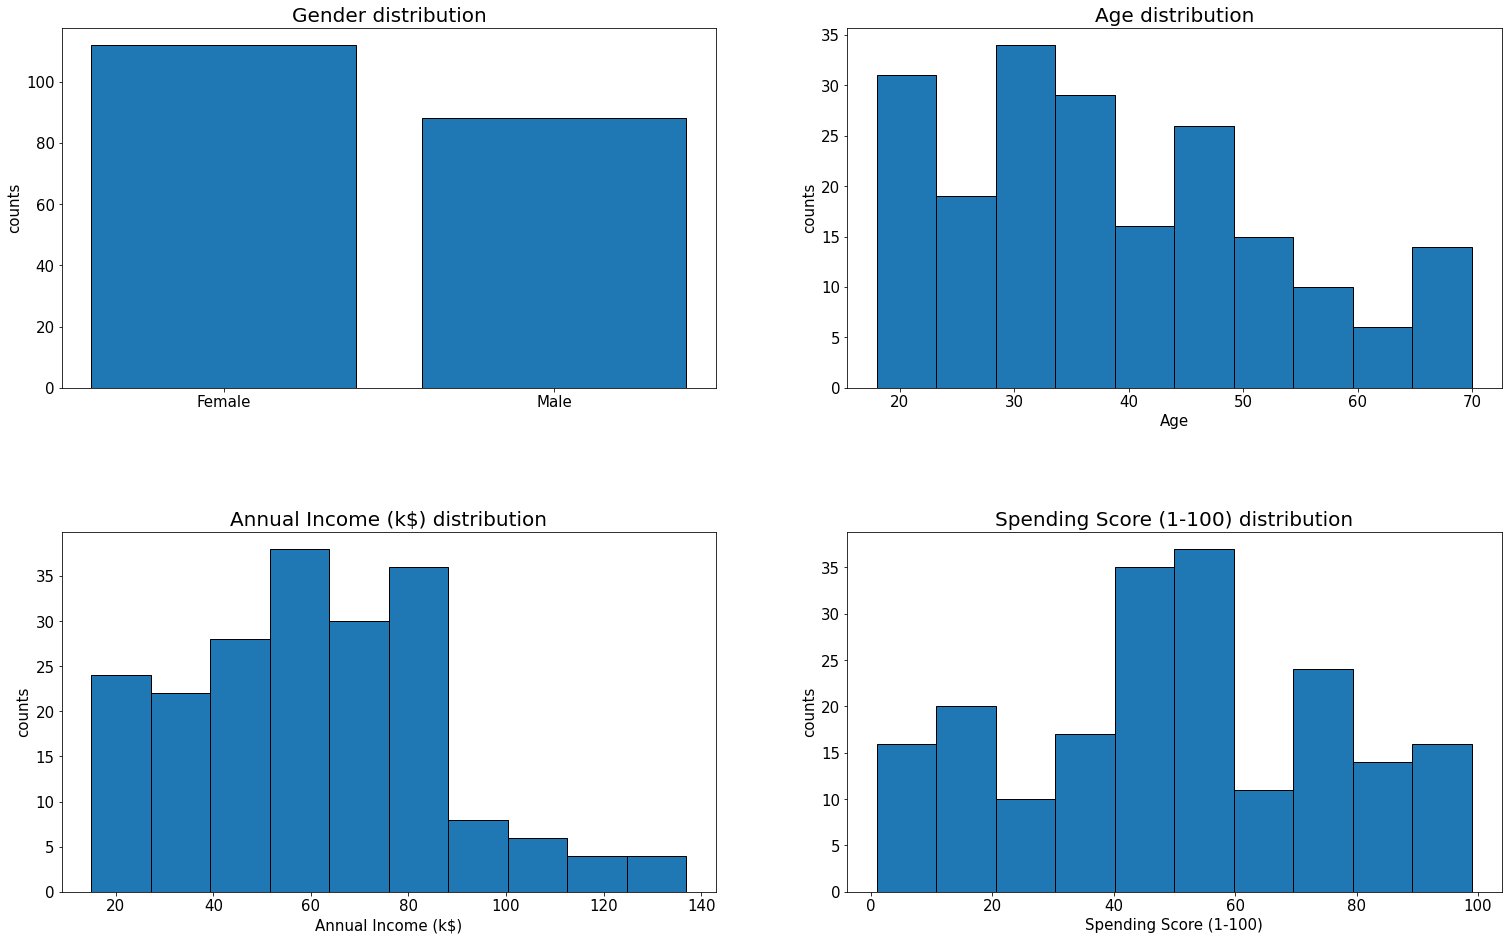

In [4]:
plot_hist(df)

In [5]:
df.iloc[0:,2:].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Outliers

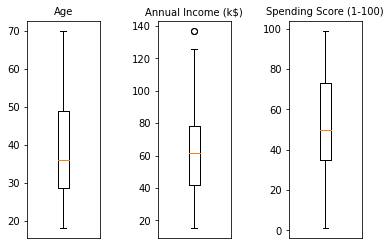

In [6]:
for i, var in enumerate(['Age',  'Annual Income (k$)', 'Spending Score (1-100)']):
    i += 1
    plt.subplot(1, 3, i)
    plt.boxplot(np.array(df[var]))
    plt.title(f'{var}', size = 10)
    plt.xticks([])
    
plt.subplots_adjust(wspace = 0.8)
    
plt.show()  

## Paired graph

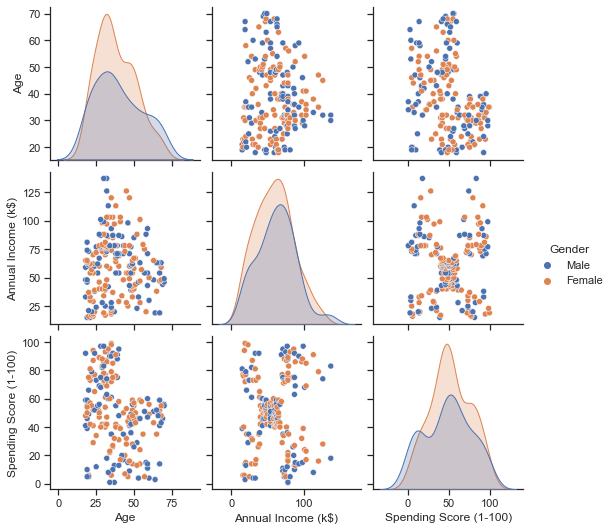

In [7]:
sns.set_theme(style="ticks")
sns.pairplot(df.iloc[:,1:], hue="Gender")

We can see that the figure which express the relationship between "Spending Score" and Annual Income suggests possible clustering formations.

## Correlation

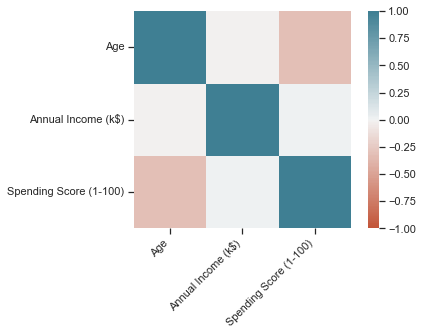

In [8]:
new_df = df.iloc[0:,2:]
cormat = new_df.corr()

ax = sns.heatmap(
    cormat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Cluster Analysis

## Elbow method

The Elbow method is a great way to indentify the optimal number of clusters. It minimizes the Within Cluster Sum of Squares (WSS), given by the following expression

$$
\sum_{k=1}^{K}\sum_{i\in S_{k}}\sum_{j=1}^{p} (x_{ij}-\bar{x}_{kj})^{2}
$$

where for each cluster "k", $S_{k}$ is the set of observations and $\bar{x}_{kj}$ is the jth center variable. We are going to use this method for centroid-based models, density-based models and hierarchical.

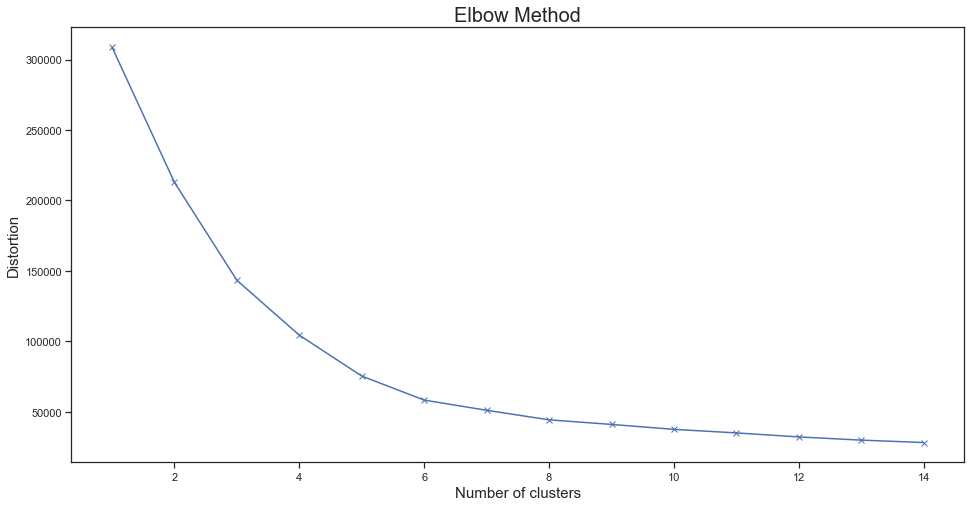

In [9]:
distortions = []
for i in range(1, 15):
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(new_df)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,15), distortions, 'bx-')
plt.xlabel('Number of clusters', size = 15)
plt.ylabel('Distortion', size = 15)
plt.title('Elbow Method', size = 20)
plt.show()

5 is the optimal number of clusters.

## Hierarchical (Agglomerative)

The agglomerative clustering is a bottom-to-top method, which beggins considering each observation as an individual cluster then start the linking process by using a specif linkage function. Here, we will adopt Ward's criteria, which link the clusters using the sum of the squared distances between the observations in each group.

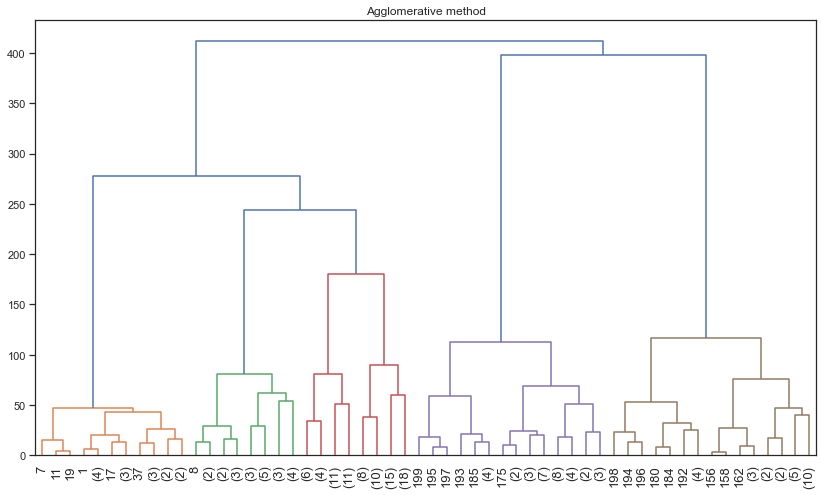

In [10]:
X = np.array(new_df)
Z = linkage(X, 'ward') # agglomerative by default
plt.figure(figsize=(14,8))
dendrogram(Z, color_threshold=200, truncate_mode = 'level', p=5)
plt.title('Agglomerative method')
ax = plt.gca()
ax.tick_params(axis='x',which='major', labelsize=13)
plt.show()

X-axis can be a group of customers or a single one.

In [11]:
agg_model = AgglomerativeClustering(n_clusters=5, linkage="ward").fit_predict(new_df)

## Centroid-Based

### K-means

K-means is a clustering method that cluster n observations into k groups where each observation belongs to te cluster with the nearest mean.

Steps:

1 - Take a sample of k centroids by first shuffling the dataset and then randomly select K data points.

2 - Assign each data point to the closest cluster (centroid).

3 - Compute the centroids for each cluster by taking the average of its data points.

4 - Keep iterating until there is no change to the centroids.

In [12]:
kmeanModel = KMeans(n_clusters=5, random_state=0)
kmeanModel.fit(new_df)

KMeans(n_clusters=5, random_state=0)

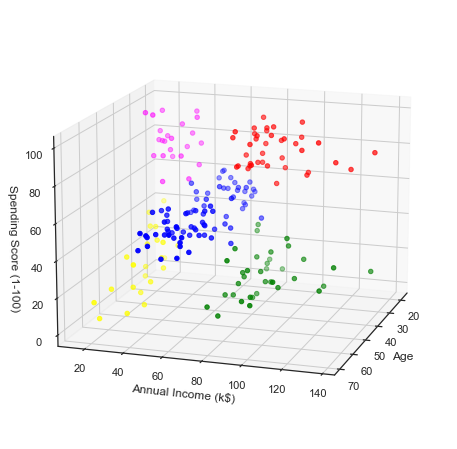

In [13]:
colors = []
for k in kmeanModel.labels_:
    colors.append(col_graph(k))
plot_graph(colors)

### PAM or K-medoids

The PAM - Partition Around Medoids algorithm is very similar to k-means, which makes it also known as k-medoids, as it seeks to find a central element (medoid) within the observations themselves that minimizes the distance between the closest elements and forms a cluster. A medoid j, for example, is given by $c_j \in (x_1,x_2,...,x_{n-1},x_n)$. 

Steps:

1 - Take a sample of size k (medoids) between all observations.

2 - Link each observation inside the database with its closest medoid.

3 - For each cluster, find the element that reproduces the least dissimilarity between the others and take it as the new medoid.

4 - Repeats steps 2 and 3 until the medoids don't change from one iteration to another.

In [14]:
kmedoids = KMedoids(n_clusters=5, random_state=0) # 0 seed to reproduction
kmedoids.fit(new_df)

KMedoids(n_clusters=5, random_state=0)

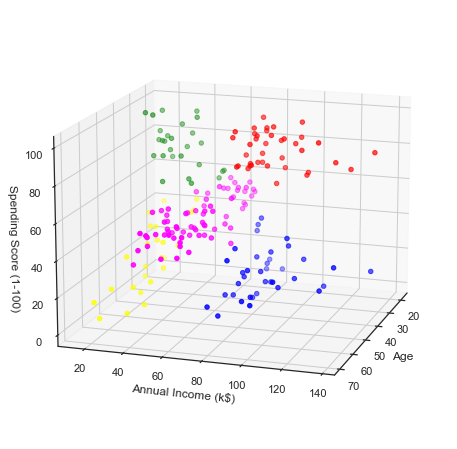

In [15]:
colors = []
for k in kmedoids.labels_:
    colors.append(col_graph(k))
plot_graph(colors)

## Density-Based

These methods don't require an initial number of clusters, but it needs two parameters to work properly. These parameters are MinPts and $\epsilon$.

- MinPts: represents the minimum number of points that a point must have inside it's neighborhood to be considered as a core.

- $\epsilon$ is the neighborhood radios of a point.

If p is a core point, then it forms a cluster with all points that are reachable from it.

To choose the best parameters for our model, we are going to use the following ideas:

- MinPts: use dimensions * 2 = 6

- $\epsilon$: create a vector of the 6th greater distance from each point to another point. Plot the ordered vector (ASC) and looks for a behavior.

In [16]:
d_matrix = euclidean_distances(new_df)

In [17]:
vec = []
for i in range(0,200):
    n = np.sort(d_matrix[i])
    vec.append(n[5])
vec = np.sort(vec)[::-1]

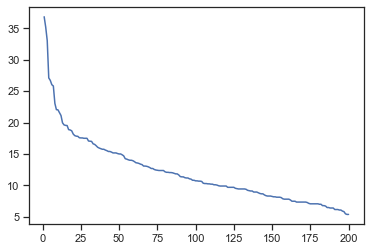

In [18]:
x = [i for i in range(1,201)]
plt.plot(x, vec)
plt.show()

Minpts = 6 and $\epsilon$ = 15

### DBSCAN

Density-based Spatial Clustering of Applications with Noise (DBSCAN), is an algorithm that groups commom observations in high-density areas and marks points that lies alone in low-density regions.

In [19]:
dbscan = DBSCAN(eps=15, min_samples=6)
dbscan.fit(new_df)

DBSCAN(eps=15, min_samples=6)

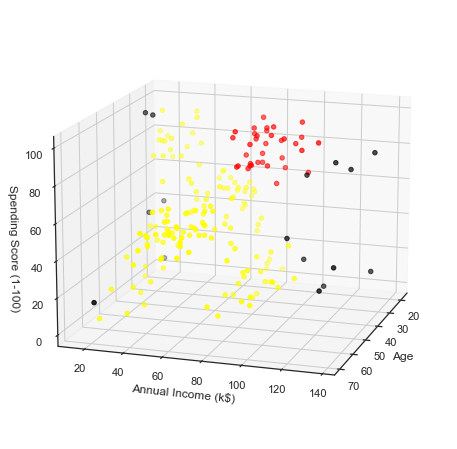

In [20]:
colors = []
for k in dbscan.labels_:
    colors.append(col_graph(k))
plot_graph(colors)

### Optics

OPTICS (Ordering Points To Identify the Clustering Structure) takes the same two parameters as DBSCAN, but it doesn't just consider the radius to link observations. In theory, it's better for finding clusters in large datasets.

In [21]:
optics = OPTICS(eps=15, min_samples=17).fit(new_df)
optics.fit(new_df)

OPTICS(eps=15, min_samples=17)

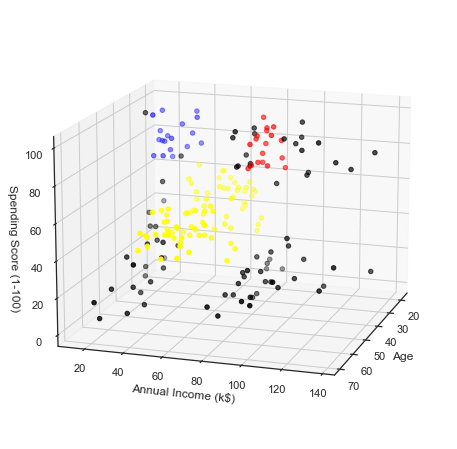

In [22]:
colors = []
for k in optics.labels_:
    colors.append(col_graph(k))
plot_graph(colors)

## Gaussian mixture models


In these models we use a mixture of multivariate normal distributions, which has the following density

$$
f(x_{j} | \mu, \Sigma) = 
\sum_{p=1}^{k} \alpha_{p} \frac{1}{\sqrt{2\pi |\Sigma_{p}|}}exp[-\frac{1}{2}(x_{j} - \mu_{p})^{t}\Sigma_{p}^{-1}(x_{j}-\mu_{p})]
$$

where p represents each cluster, $\alpha_p$ is the weight for pth gaussian distribution, $\mu$ is a mean vector of the dataset atributtes and $\Sigma$ is the covariance matrix. 

To estimate the parameters whe use the Expectation-maximization (EM) algorithm.

### Bayesian Information Criterion

Bayesian Information Criterion can easily help us to define the optimal number of clusters and the best model in model-based clustering. The idea is to find a model from a set of candidates that maximizes the posterior probability of an observation x to belong to a cluster y.

We calculate BIC by

$$
klog(n) - 2\sum L_{i}
$$

where n is the sample size, $L_{i}$ represents the log-likelihood of cluster "i" and k is the number of free parameters. We are going to use this method to find out the best model and number of clusters.

In [23]:
# obtaining BIC value for each model and saving it into an array.
X = np.array(new_df)
methds = ['full', 'tied', 'diag', 'spherical']
Bic = [[0 for i in range(0,len(methds))] for i in range(1,15)]
for i in range(1,15):
    for j, m in enumerate(methds):
        gm = GaussianMixture(n_components=i, random_state=0, covariance_type=m).fit(X).bic(X)
        Bic[i-1][j] = gm
        
Bic = np.array(Bic)
Bic_df = pd.DataFrame(Bic, columns=methds)

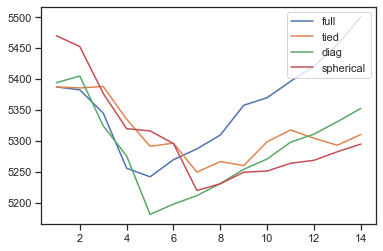

In [24]:
for col in methds:
    plt.subplot(1, 1, 1)
    plt.plot([x for x in range(1,15)], Bic_df[col], label=col)
plt.legend(loc="upper right")
plt.show()

Covariance type as diag and n=5 looks good.

In [25]:
# creating the GMM model busing n=5 components and type=diag
gm = GaussianMixture(n_components=5, random_state=0, covariance_type = 'diag').fit(X).predict(X)

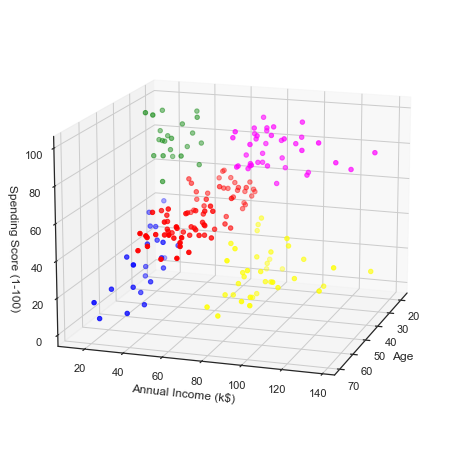

In [26]:
colors = []
for k in gm:
    colors.append(col_graph(k))
plot_graph(colors)

# Final Model

To pick a model we are going to use silhouette scores.

## Silhouette score

Given a set of clusters $\Lambda$, we define the silhouette of an observation "i" inside a cluster $\lambda_k$ as

$$
    s_{i\lambda_k} = \frac{b_i - a_i}{max(b_i, a_i)}
$$

where $a_i$ is the dissimilarity of "i" related to the elements of cluster $\lambda_k$ (which contains "i") and $b_i$ is the smallest dissimilarity of i with respect to the elements of another cluster $\lambda$, that is, $b_i = min_{\lambda \neq \lambda_k} d (i, \lambda)$

In [27]:
print(f'Agglomerative: {silhouette_score(new_df, agg_model)}')
print(f'K-means: {silhouette_score(new_df,kmeanModel.labels_)}')
print(f'K-medoids(PAM): {silhouette_score(new_df,kmedoids.labels_)}')
print(f'DBSCAN: {silhouette_score(new_df, dbscan.labels_)}')
print(f'Optics: {silhouette_score(new_df, optics.labels_)}')
print(f'Gaussian MM: {silhouette_score(new_df,gm)}')

Agglomerative: 0.4401889024290193
K-means: 0.44428597560893024
K-medoids(PAM): 0.43213619168066986
DBSCAN: 0.27597205595332247
Optics: 0.18014982255947692
Gaussian MM: 0.4439157227759096


Silhouette scores suggests that **K-means is our best fit**. The following code aims to analyze the formed clusters using PCA and Histograms.

## PCA - Principal Component Analysis

It's always a good idea to normalize the data before reducing dimensions.

In [28]:
# normalize
X_normalized = preprocessing.normalize(np.array(new_df), norm='l2')
pca = PCA(n_components=2)
pca.fit(X_normalized)
print(pca.explained_variance_ratio_)

[0.6180081  0.35187797]


In [29]:
# transformation and labeling
X = pca.transform(X_normalized)
X = pd.DataFrame(X, columns = ['PCA1', 'PCA2'])
X['cluster'] = kmeanModel.labels_

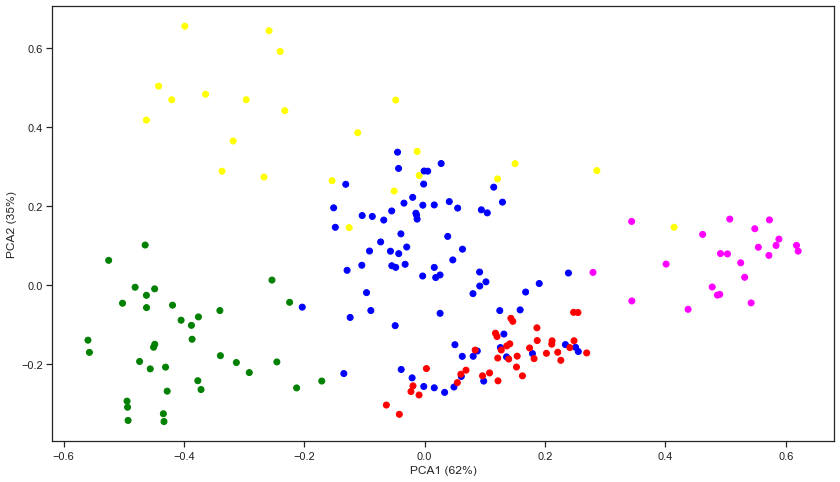

In [30]:
# coloring according to each cluster label
colors = []
for k in kmeanModel.labels_:
    colors.append(col_graph(k))

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot()
ax.set_xlabel('PCA1 (62%)')
ax.set_ylabel('PCA2 (35%)')
ax.scatter(X.iloc[0:, 0], X.iloc[0:, 1], c=colors)
plt.show()

## Distributions of clusters

In [31]:
df['kmeans'] = kmeanModel.labels_

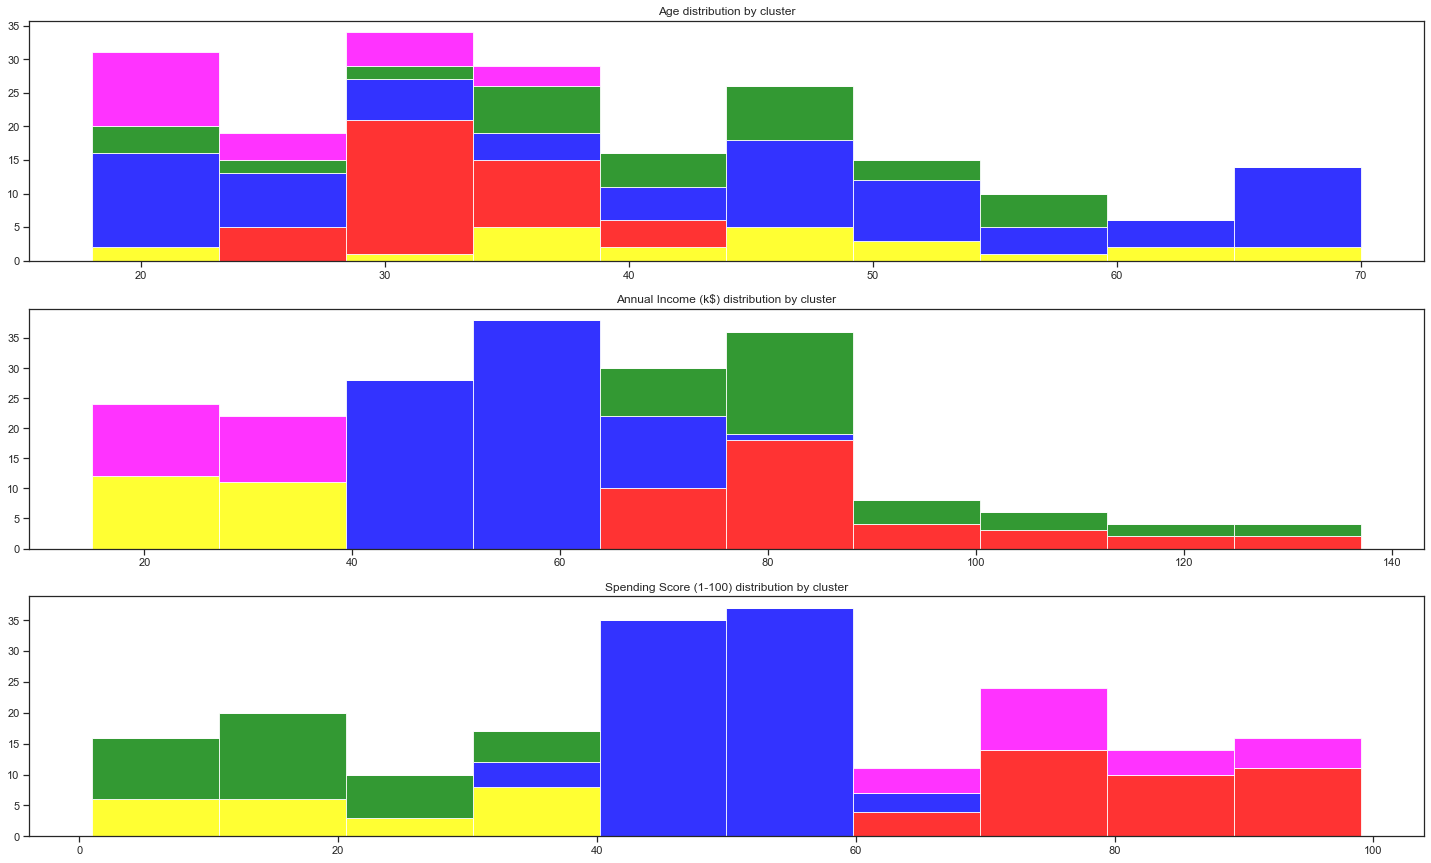

In [32]:
col = np.array(['yellow', 'red', 'blue', 'green', 'magenta'])
vari = np.array(['Age', 'Annual Income (k$)','Spending Score (1-100)'])

plt.figure(figsize=(25, 15))
for i, var in enumerate(vari):
    data_new = [func(i, var) for i in range(0,5)]
    plt.subplot(3,1,i+1)
    plt.hist(data_new, histtype='barstacked', color=col, alpha=0.8)
    plt.title(f'{var} distribution by cluster')
plt.show()

In [33]:
df.groupby(['kmeans','Gender']).size().reset_index(name='counts')
# ['yellow', 'red', 'blue', 'green', 'magenta'] = [0, 1, 2, 3, 4]

,kmeans,Gender,counts
0,0,Female,14
1,0,Male,9
2,1,Female,21
3,1,Male,18
4,2,Female,46
5,2,Male,33
6,3,Female,17
7,3,Male,19
8,4,Female,14
9,4,Male,9


# Conclusion

**Yellow cluster** : Diversity of age. Low annual income (max = 40). Spending score lies down between 0 and 40 (low).

**Green cluster** : Age going from 18 to near 60's. Higher annual income  (60 to almost 140). Lower spending score.

**Blue cluster** : Diversity of age, but it has older people than the others. Annual income lies between 40 and 90. Spending scores concentrates in the middle of the graph.

**Magenta cluster** : Cluster of younger people, with age between 18 and almost 40. Low annual income. High spending scores.

**Red cluster** : Group of customers where age goes from middle of tweenties to almost 45. High annual income (60 to almost 140). High spending scores (60 to 100).